In [1]:
# Downloading the data
!gdown 1iqYLFVKySREVm5Kn5NagMeHaDi-dVLcj

Downloading...
From: https://drive.google.com/uc?id=1iqYLFVKySREVm5Kn5NagMeHaDi-dVLcj
To: /home/user/Uni/NGS/Ribo/HSE_RiboSeq_HT.zip
100%|██████████████████████████████████████| 4.84M/4.84M [00:00<00:00, 14.3MB/s]


In [2]:
# Unpacking
!unzip HSE_RiboSeq_HT.zip

Archive:  HSE_RiboSeq_HT.zip
   creating: HSE_RiboSeq_HT/
  inflating: __MACOSX/._HSE_RiboSeq_HT  
  inflating: HSE_RiboSeq_HT/02. RiboSeq_EColi_track_r.wig  
  inflating: __MACOSX/HSE_RiboSeq_HT/._02. RiboSeq_EColi_track_r.wig  
  inflating: HSE_RiboSeq_HT/02. RiboSeq_EColi_track_f.wig  
  inflating: __MACOSX/HSE_RiboSeq_HT/._02. RiboSeq_EColi_track_f.wig  
  inflating: HSE_RiboSeq_HT/01. RiboSeq_RNASeq_HCC_counts.tsv  
  inflating: __MACOSX/HSE_RiboSeq_HT/._01. RiboSeq_RNASeq_HCC_counts.tsv  


In [75]:
# Reading dataset
import pandas as pd

counts = pd.read_csv("HSE_RiboSeq_HT/01. RiboSeq_RNASeq_HCC_counts.tsv", sep="\t")
genes = list(counts["geneSymbol"])
del counts["geneID"], counts["geneSymbol"]
counts = counts.fillna(0)

counts

,LC001-normal-RPF,LC001-tumor-RPF,LC001-normal-RNA,LC001-tumor-RNA,LC033-normal-RPF,LC033-tumor-RPF,LC033-normal-RNA,LC033-tumor-RNA,LC034-normal-RPF,LC034-tumor-RPF,...,LC507-normal-RNA,LC507-tumor-RNA,LC508-normal-RPF,LC508-tumor-RPF,LC508-normal-RNA,LC508-tumor-RNA,LC509-normal-RPF,LC509-tumor-RPF,LC509-normal-RNA,LC509-tumor-RNA
0,0,0,402,873,0,0,301,1627,0,0,...,218,457,0,0,200,889,0,0,161,857.0
1,0,0,0,1,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0.0
2,168,239,88,187,114,439,66,201,325,117,...,92,170,109,357,60,244,141,173,56,83.0
3,65,121,60,106,36,163,70,156,130,76,...,127,176,67,176,55,261,64,100,68,176.0
4,8,43,18,70,16,76,4,63,44,14,...,124,437,7,167,34,201,6,61,9,58.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18940,0,0,1,39,0,0,0,5,0,0,...,0,31,0,6,0,62,0,0,1,17.0
18941,0,4,27,5,0,32,20,51,0,6,...,81,52,1,0,9,42,0,10,3,40.0
18942,0,0,0,0,0,0,10,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
18943,0,9,0,0,0,0,0,0,0,7,...,0,0,0,0,0,0,0,0,0,0.0


# 1.1 Corr between Ribo and RNA for each gene

In [76]:
#rearrange dataframe in a more convinient way. RPFs first, RNAs next
order = []
for i in range(0,10):
    order.extend([i*4, i*4+1])
for i in range(0,10):
    order.extend([i*4+2, i*4+3])
counts = counts.iloc[:,order]
counts.head(3)

,LC001-normal-RPF,LC001-tumor-RPF,LC033-normal-RPF,LC033-tumor-RPF,LC034-normal-RPF,LC034-tumor-RPF,LC501-normal-RPF,LC501-tumor-RPF,LC502-normal-RPF,LC502-tumor-RPF,...,LC505-normal-RNA,LC505-tumor-RNA,LC506-normal-RNA,LC506-tumor-RNA,LC507-normal-RNA,LC507-tumor-RNA,LC508-normal-RNA,LC508-tumor-RNA,LC509-normal-RNA,LC509-tumor-RNA
0,0,0,0,0,0,0,0,0,0,0,...,153,361,157,333,218,457,200,889,161,857.0
1,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0.0
2,168,239,114,439,325,117,106,192,118,292,...,61,155,104,114,92,170,60,244,56,83.0


While this is true that the data is raw counts and it could be transformed to TPM and then log1p-ified, the documentation on DESeq2 says the following on the matter: <br> 
__The DESeq2 model internally corrects for library size, so transformed or normalized values such as counts scaled by library size should not be used as input.__ <br>
[source](http://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#why-un-normalized-counts) (chapter 'Input Data')

In [6]:
import scipy
#correlation between Ribo an RNA. For every row list of first 20 values vs list of last 20 values
counts['mods_corr'] = counts.apply(lambda x: scipy.stats.spearmanr(a = x.iloc[:20], b = x.iloc[20:])[0], axis = 1)

/home/user/miniconda3/envs/NGSenv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/tmp/ipykernel_6007/3821937056.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  counts['mods_corr'] = counts.apply(lambda x: scipy.stats.spearmanr(a = x.iloc[:20], b = x.iloc[20:])[0], axis = 1)


In [7]:
counts['mods_corr']

0             NaN
1       -0.139424
2        0.849624
3        0.697779
4        0.811583
           ...   
18940    0.382301
18941    0.191364
18942         NaN
18943         NaN
18944    0.443724
Name: mods_corr, Length: 18945, dtype: float64

In [8]:
#the NANs are caused by constant in one of the modalities (all are zeros)
print(list(counts.iloc[0,0:20]), end = ', ')

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 

In [9]:
#thus, it means corr must be zero. Replacing nans with zeros
counts = counts.fillna(0)
counts['mods_corr'].head()

0    0.000000
1   -0.139424
2    0.849624
3    0.697779
4    0.811583
Name: mods_corr, dtype: float64

The rationale behind using Spearman correlation is that the relationship between biological data isn't linear so it's better to use more robust Spearman correlation. This relationship also might be non-monotonous but using something like [distance correlation](https://en.wikipedia.org/wiki/Distance_correlation) for this case would be too much. 

# 1.2 Histogram and biggest/smallest correlated genes

<AxesSubplot:>

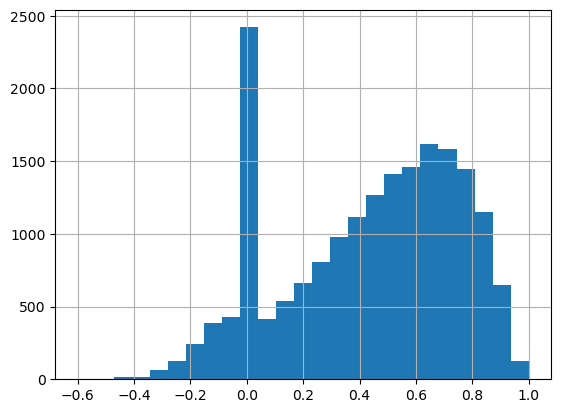

In [10]:
counts['mods_corr'].hist(bins = 25)

Just as expected, when all samples from one modality had the same number of counts (most probably zero), it lead to zero correlation and it formed a column at 0. 

In [11]:
#let's look at the big positive and big negative correlations
counts.sort_values(by = 'mods_corr') #rightmost column

,LC001-normal-RPF,LC001-tumor-RPF,LC033-normal-RPF,LC033-tumor-RPF,LC034-normal-RPF,LC034-tumor-RPF,LC501-normal-RPF,LC501-tumor-RPF,LC502-normal-RPF,LC502-tumor-RPF,...,LC505-tumor-RNA,LC506-normal-RNA,LC506-tumor-RNA,LC507-normal-RNA,LC507-tumor-RNA,LC508-normal-RNA,LC508-tumor-RNA,LC509-normal-RNA,LC509-tumor-RNA,mods_corr
17336,2,15,0,2,2,19,10,3,0,3,...,1,10,0,15,3,3,0,1,1.0,-0.599996
1807,0,1,0,0,0,0,0,2,0,0,...,3,111,70,149,17,25,4,30,7.0,-0.588242
13994,0,0,0,0,7,10,0,0,2,4,...,33,24,21,7,17,26,58,11,45.0,-0.587297
100,0,2,0,2,0,0,0,3,0,0,...,4,26,6,21,2,25,2,8,4.0,-0.561372
7707,0,0,0,3,0,4,0,1,0,0,...,0,4,1,9,3,4,1,2,3.0,-0.551351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13578,0,0,0,0,0,0,0,0,0,0,...,5,0,0,0,2,0,0,0,0.0,1.000000
17480,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,1.000000
17597,0,0,0,0,0,0,0,0,0,0,...,33,0,4,0,0,0,0,0,0.0,1.000000
9754,0,0,0,0,0,0,0,0,6,0,...,0,0,0,0,0,0,0,0,0.0,1.000000


In [12]:
# It can be seen that such big correlations are caused by abundance zeros. 
#Just a few pairs of none-zeros values causes correlation to be equal 1.
counts.iloc[18124]

LC001-normal-RPF     0.0
LC001-tumor-RPF      0.0
LC033-normal-RPF     0.0
LC033-tumor-RPF      0.0
LC034-normal-RPF     0.0
LC034-tumor-RPF      0.0
LC501-normal-RPF     0.0
LC501-tumor-RPF      0.0
LC502-normal-RPF     0.0
LC502-tumor-RPF      0.0
LC505-normal-RPF     0.0
LC505-tumor-RPF     36.0
LC506-normal-RPF     0.0
LC506-tumor-RPF      0.0
LC507-normal-RPF     0.0
LC507-tumor-RPF      0.0
LC508-normal-RPF     0.0
LC508-tumor-RPF      0.0
LC509-normal-RPF     0.0
LC509-tumor-RPF     35.0
LC001-normal-RNA     0.0
LC001-tumor-RNA      0.0
LC033-normal-RNA     0.0
LC033-tumor-RNA      0.0
LC034-normal-RNA     0.0
LC034-tumor-RNA      0.0
LC501-normal-RNA     0.0
LC501-tumor-RNA      0.0
LC502-normal-RNA     0.0
LC502-tumor-RNA      0.0
LC505-normal-RNA     0.0
LC505-tumor-RNA     30.0
LC506-normal-RNA     0.0
LC506-tumor-RNA      0.0
LC507-normal-RNA     0.0
LC507-tumor-RNA      0.0
LC508-normal-RNA     0.0
LC508-tumor-RNA      0.0
LC509-normal-RNA     0.0
LC509-tumor-RNA     27.0


In [13]:
#even if most values aren't zeros, it still introduces a lot of noise
#which leads to a significant correlation/anticorrelation
counts.iloc[17336]

LC001-normal-RPF     2.000000
LC001-tumor-RPF     15.000000
LC033-normal-RPF     0.000000
LC033-tumor-RPF      2.000000
LC034-normal-RPF     2.000000
LC034-tumor-RPF     19.000000
LC501-normal-RPF    10.000000
LC501-tumor-RPF      3.000000
LC502-normal-RPF     0.000000
LC502-tumor-RPF      3.000000
LC505-normal-RPF     0.000000
LC505-tumor-RPF      3.000000
LC506-normal-RPF     0.000000
LC506-tumor-RPF      3.000000
LC507-normal-RPF     1.000000
LC507-tumor-RPF      3.000000
LC508-normal-RPF     2.000000
LC508-tumor-RPF      6.000000
LC509-normal-RPF     0.000000
LC509-tumor-RPF      3.000000
LC001-normal-RNA     2.000000
LC001-tumor-RNA      0.000000
LC033-normal-RNA     0.000000
LC033-tumor-RNA      0.000000
LC034-normal-RNA     0.000000
LC034-tumor-RNA      0.000000
LC501-normal-RNA     0.000000
LC501-tumor-RNA      0.000000
LC502-normal-RNA    10.000000
LC502-tumor-RNA      0.000000
LC505-normal-RNA     7.000000
LC505-tumor-RNA      1.000000
LC506-normal-RNA    10.000000
LC506-tumo

Thus, most extreme correlations are caused by statistical artifacts and not by underlying biology.

# 1.3 Dispersion vs average

In [14]:
#calculationg and adding averages for Ribo-seq
counts['ribo_average'] = counts.iloc[:,10:20].mean(axis = 1)
counts['ribo_var'] = counts.iloc[:,10:20].var(axis = 1)

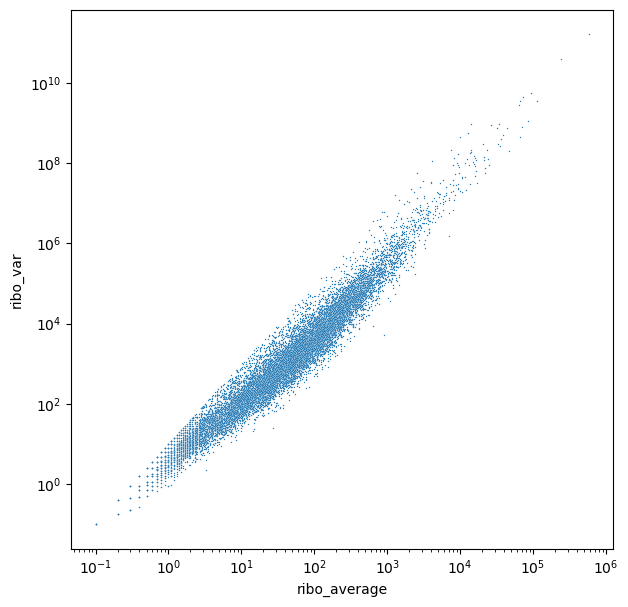

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="log", yscale="log")
ax = sns.scatterplot(data = counts, x = 'ribo_average', y = 'ribo_var', s = 1)

/home/user/miniconda3/envs/NGSenv/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/user/miniconda3/envs/NGSenv/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


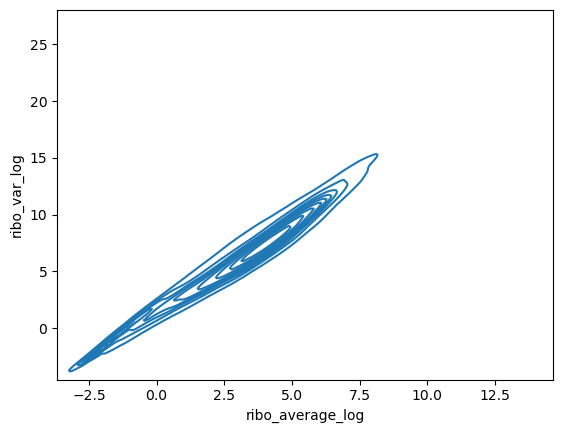

In [16]:
#Looks like there is the expected curvaturet's too difficult to see much from 
import numpy as np
counts['ribo_average_log'] = np.log(counts['ribo_average'])
counts['ribo_var_log'] = np.log(counts['ribo_var'])
ax = sns.kdeplot(data = counts, x = 'ribo_average_log', y = 'ribo_var_log')

It's possible to see the curvature which we would expect from the negative binomial.

As for the test how to check whether it's really NB, I would suggest doing the following:<br>
First we fit negative binomial distribution, normal distribution and poisson distribution by their parameters using maximum likelihood. Then, we use chi-square statistics as described [here](https://stats.stackexchange.com/a/307989) and do visual examination whether NB looks more consistent in terms of distributions for p-values we calculated for each gene.  <br>
source: https://stats.stackexchange.com/questions/307814/negative-binomial-distribution

# 1.4 DE for ribo, RNA, method

Here, I'm reusing the code provided by the lecturer several times.

In [17]:
#!conda install -c conda-forge matplotlib-venn

In [18]:
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

DESeq2 = importr("DESeq2")

## ribo

In [19]:
# Design matrix
design = pd.DataFrame({
    "condition": [sample_name.split("-")[1] for sample_name in counts.iloc[:,0:20].columns],
}, index=counts.iloc[:,0:20].columns)

with localconverter(ro.pandas2ri.converter):
    countData = pandas2ri.py2rpy(counts.iloc[:,0:20].astype(int))
    colData = pandas2ri.py2rpy(design)


design.head()

,condition
LC001-normal-RPF,normal
LC001-tumor-RPF,tumor
LC033-normal-RPF,normal
LC033-tumor-RPF,tumor
LC034-normal-RPF,normal


In [20]:
dds = DESeq2.DESeqDataSetFromMatrix(
    countData=countData,
    colData=colData,
    design=ro.Formula("~ condition"),
)

dds = DESeq2.DESeq(dds)

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 888 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



In [21]:
# Getting the results
to_dataframe = ro.r("function(x) data.frame(x)")
dds_results = to_dataframe(DESeq2.results(dds))
#dds_results = to_dataframe(DESeq2.results(dds, name="conditiontumor.experimentRPF"))

with localconverter(pandas2ri.converter):
    dds_results = ro.conversion.rpy2py(dds_results)
    dds_results.index = genes

In [22]:
dds_results

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
TSPAN6,0.000000,NaN,NaN,NaN,NaN,NaN
TNMD,0.134227,-0.497105,3.026188,-0.164268,0.869521,NaN
DPM1,187.335949,-0.111414,0.207386,-0.537228,0.591110,0.750365
SCYL3,88.779354,0.055055,0.245021,0.224694,0.822217,0.904063
C1orf112,42.182053,1.367345,0.481942,2.837153,0.004552,0.030767
...,...,...,...,...,...,...
RP1-34B20.21,0.154862,0.626800,3.020013,0.207549,0.835581,NaN
RP11-511P7.5,4.416458,3.562810,1.221427,2.916924,0.003535,0.025481
KLF18,0.000000,NaN,NaN,NaN,NaN,NaN
TRBV6-2,1.040643,0.921821,2.795457,0.329757,0.741584,NaN


/home/user/miniconda3/envs/NGSenv/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0, 0.5, 'log$_{10}$FDR')

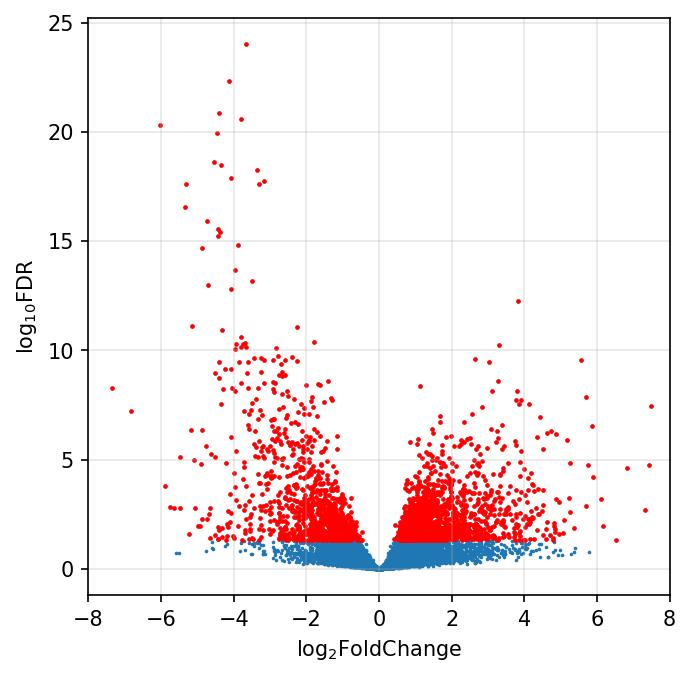

In [23]:
# Volcano

p_tr = 0.05

fig, ax = plt.subplots(figsize=(5, 5), dpi=150)
xlim = max(-min(dds_results.log2FoldChange), (max(dds_results.log2FoldChange))) + 0.5

sns.scatterplot(
    x=dds_results.log2FoldChange,
    y=-np.log10(dds_results.padj),
    ax=ax,
    s=3,
    linewidth=0,
)


sns.scatterplot(
    x=dds_results[dds_results.padj < p_tr].log2FoldChange,
    y=-np.log10(dds_results[dds_results.padj < p_tr].padj),
    ax=ax,
    s=5,
    linewidth=0,
    color="red",
)

ax.grid(alpha=0.3)

ax.set_xlim(-8, 8)
ax.set_xlabel("log$_2$FoldChange")
ax.set_ylabel("log$_{10}$FDR")

In [24]:
#acquiring the list of genes which are DE (by FDR) for ribo-seq
DE_ribo = dds_results[dds_results['padj'] < 0.05]['padj']
DE_ribo_set = set(DE_ribo.index)
DE_ribo.sort_values(ascending = True).head(), DE_ribo.shape

(CETP      9.219850e-25
 OIT3      4.782557e-23
 TIMD4     1.360522e-21
 ADGRA3    2.659546e-21
 CLEC4M    4.937702e-21
 Name: padj, dtype: float64,
 (2543,))

## RNA

In [25]:
# Design matrix
design = pd.DataFrame({
    "condition": [sample_name.split("-")[1] for sample_name in counts.iloc[:,20:40].columns],
}, index=counts.iloc[:,20:40].columns)

with localconverter(ro.pandas2ri.converter):
    countData = pandas2ri.py2rpy(counts.iloc[:,20:40].astype(int))
    colData = pandas2ri.py2rpy(design)


design.head()

,condition
LC001-normal-RNA,normal
LC001-tumor-RNA,tumor
LC033-normal-RNA,normal
LC033-tumor-RNA,tumor
LC034-normal-RNA,normal


In [26]:
dds = DESeq2.DESeqDataSetFromMatrix(
    countData=countData,
    colData=colData,
    design=ro.Formula("~ condition"),
)

dds = DESeq2.DESeq(dds)

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 1242 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



In [27]:
# Getting the results
to_dataframe = ro.r("function(x) data.frame(x)")
dds_results = to_dataframe(DESeq2.results(dds))
#dds_results = to_dataframe(DESeq2.results(dds, name="conditiontumor.experimentRPF"))

with localconverter(pandas2ri.converter):
    dds_results = ro.conversion.rpy2py(dds_results)
    dds_results.index = genes

In [28]:
dds_results

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
TSPAN6,406.279268,1.016935,0.396326,2.565906,1.029066e-02,0.038159
TNMD,0.255801,-0.756176,3.025600,-0.249926,8.026445e-01,NaN
DPM1,105.871975,0.636650,0.319406,1.993232,4.623607e-02,0.120018
SCYL3,104.480304,0.305490,0.238250,1.282226,1.997634e-01,0.348097
C1orf112,62.812560,1.553462,0.547881,2.835400,4.576828e-03,0.020282
...,...,...,...,...,...,...
RP1-34B20.21,10.083912,4.424619,0.799486,5.534333,3.124156e-08,0.000002
RP11-511P7.5,37.107729,0.602483,0.415340,1.450575,1.468982e-01,0.279452
KLF18,0.614809,-2.986452,2.990443,-0.998665,3.179569e-01,NaN
TRBV6-2,0.000000,NaN,NaN,NaN,NaN,NaN


/home/user/miniconda3/envs/NGSenv/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0, 0.5, 'log$_{10}$FDR')

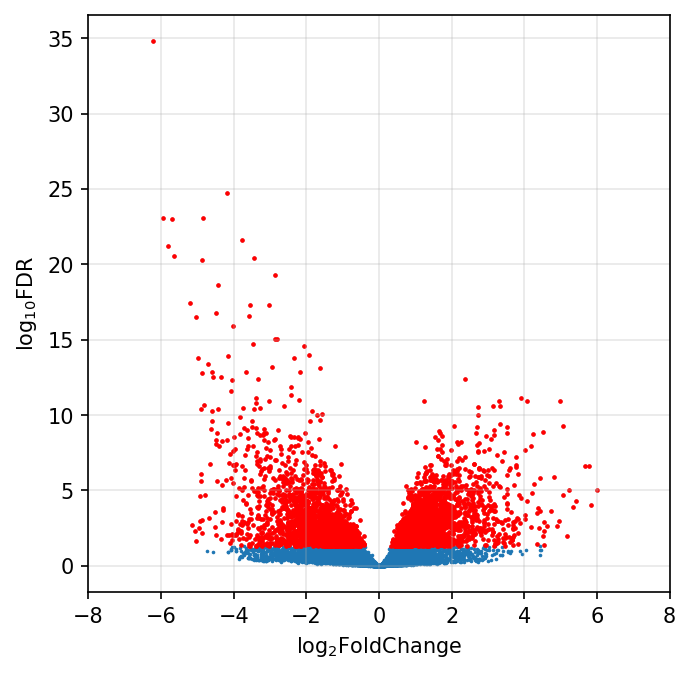

In [29]:
# Volcano

p_tr = 0.05

fig, ax = plt.subplots(figsize=(5, 5), dpi=150)
xlim = max(-min(dds_results.log2FoldChange), (max(dds_results.log2FoldChange))) + 0.5

sns.scatterplot(
    x=dds_results.log2FoldChange,
    y=-np.log10(dds_results.padj),
    ax=ax,
    s=3,
    linewidth=0,
)


sns.scatterplot(
    x=dds_results[dds_results.padj < p_tr].log2FoldChange,
    y=-np.log10(dds_results[dds_results.padj < p_tr].padj),
    ax=ax,
    s=5,
    linewidth=0,
    color="red",
)

ax.grid(alpha=0.3)

ax.set_xlim(-8, 8)
ax.set_xlabel("log$_2$FoldChange")
ax.set_ylabel("log$_{10}$FDR")

In [30]:
#acquiring the list of genes which are DE (by FDR) for ribo-seq
DE_RNA = dds_results[dds_results['padj'] < 0.05]['padj']
DE_RNA_set = set(DE_RNA.index)
DE_RNA.sort_values(ascending = True).head(), DE_RNA.shape

(CLEC4G      1.464478e-35
 OIT3        1.884400e-25
 AVPR1A      8.917125e-24
 INS-IGF2    8.917125e-24
 FCN2        9.876861e-24
 Name: padj, dtype: float64,
 (4812,))

## Comparing ribo and RNA DE-genes

In [31]:
from matplotlib_venn import venn2

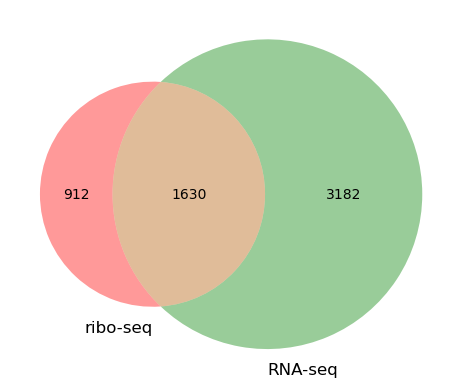

In [32]:
DE_ribo_RNA_set = DE_ribo_set & DE_RNA_set
venn2((DE_ribo_set, DE_RNA_set), set_labels = ('ribo-seq', 'RNA-seq'))

As we can see, there were more RNA-seq DE-genes compared to ribo-seq RNA-genes. They only partially overlapped. <br>
We could cautiously suggest that:
* Only a part of overexpressed genes actually reach the translation step
* There are some genes which have different intensity of translation in tumor, even though transcripts aren't overexpressed
* We should note that there is some noise (FDR < 0.05) so the difference between the two modalities can be a little bit lower
* We should note that we don't know the ground truth on actual numbers. For example, tumor cell can some genes much more while not expressing other genes less. But expression of this genes still will appear lower because sequencing deals with fractions, not absolute numbers. It's possible that having more DE-genes in RNA is caused by data being much more skewed by this factor and number of DE-genes is overestimated

In [33]:
#let's choose a represantive from both modalities which aren't in the intersection
#the source for description is genecards.org
DE_ribo[~DE_ribo.isin(DE_ribo_RNA_set)].sort_values(ascending = True).head(1)

CETP    9.219850e-25
Name: padj, dtype: float64

The protein encoded by this gene is found in plasma, where it is involved in the transfer of cholesteryl ester from high density lipoprotein (HDL) to other lipoproteins. Defects in this gene are a cause of hyperalphalipoproteinemia

In [34]:
DE_RNA[~DE_RNA.index.isin(DE_ribo_RNA_set)].sort_values(ascending = True).head(1)

HSPB6    2.634877e-11
Name: padj, dtype: float64

This locus encodes a heat shock protein. The encoded protein likely plays a role in smooth muscle relaxation.

In [35]:
#let's choose a represantative from the intersection
DE_ribo[DE_ribo.index.isin(DE_ribo_RNA_set)].sort_values(ascending = True).head(1)

CETP    9.219850e-25
Name: padj, dtype: float64

This gene encodes a glycan-binding receptor and member of the C-type lectin family which plays a role in the immune response. C-type lectin receptors are pattern recognition receptors located on immune cells that play a role in the recognition and uptake of both self and non-self glycoproteins as well as mediating cell adhesion, glycoprotein clearance, and cell signaling functions.

Looks much more relevant compared to genes compared to the representatives from non-intersecting genes. It plays a role in the immune response. Perhaps, participates in immunity evasion?

## ~ condition + experiment + experiment:condition

In [38]:
design = pd.DataFrame({
    "condition": [sample_name.split("-")[1] for sample_name in counts.iloc[:,0:40].columns],
    "experiment": [sample_name.split("-")[2] for sample_name in counts.iloc[:,0:40].columns],
}, index=counts.iloc[:,0:40].columns)

DESeq2 = importr("DESeq2")

with localconverter(ro.pandas2ri.converter):
    countData = pandas2ri.py2rpy(counts.iloc[:,0:40].astype(int))
    colData = pandas2ri.py2rpy(design)

design.head()

,condition,experiment
LC001-normal-RPF,normal,RPF
LC001-tumor-RPF,tumor,RPF
LC033-normal-RPF,normal,RPF
LC033-tumor-RPF,tumor,RPF
LC034-normal-RPF,normal,RPF


In [39]:
dds = DESeq2.DESeqDataSetFromMatrix(
    countData=countData,
    colData=colData,
    design=ro.Formula("~ condition + experiment + experiment:condition"),
)

dds = DESeq2.DESeq(dds)

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 783 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



In [40]:
to_dataframe = ro.r("function(x) data.frame(x)")
dds_results = to_dataframe(DESeq2.results(dds, name="conditiontumor.experimentRPF"))

with localconverter(pandas2ri.converter):
    dds_results = ro.conversion.rpy2py(dds_results)
    dds_results.index = genes

In [41]:
dds_results

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
TSPAN6,157.314698,-1.708536,1.071524,-1.594493,0.110826,0.609760
TNMD,0.185139,0.305798,5.912838,0.051718,0.958754,NaN
DPM1,157.609670,-0.664381,0.348364,-1.907145,0.056502,0.489304
SCYL3,96.555209,-0.180154,0.316026,-0.570059,0.568638,0.915436
C1orf112,50.909678,-0.088034,0.736560,-0.119521,0.904863,0.985700
...,...,...,...,...,...,...
RP1-34B20.21,4.060544,-3.660062,1.640161,-2.231526,0.025646,0.397689
RP11-511P7.5,17.658822,2.975326,1.040298,2.860070,0.004235,0.228113
KLF18,0.253832,2.284850,5.894346,0.387634,0.698287,NaN
TRBV6-2,0.644714,1.430520,5.881852,0.243209,0.807843,0.970499


/home/user/miniconda3/envs/NGSenv/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0, 0.5, 'log$_{10}$FDR')

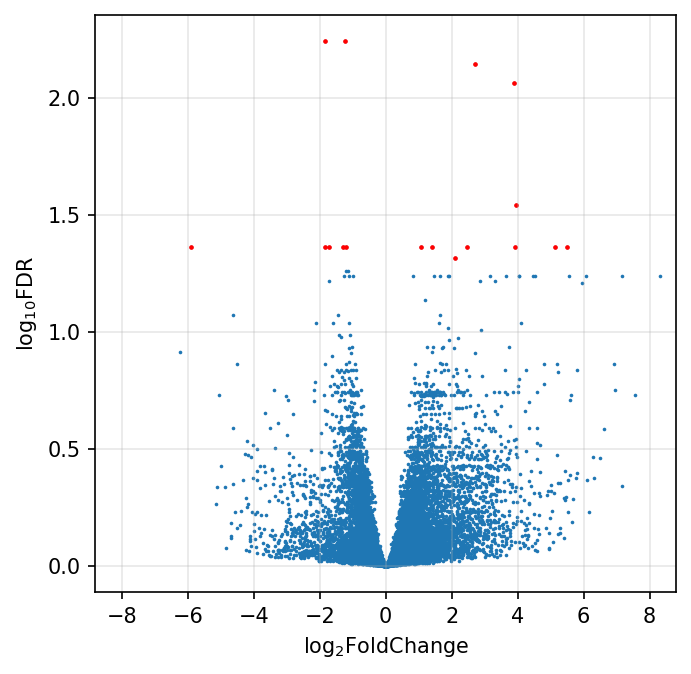

In [42]:
# Volcano

p_tr = 0.05

fig, ax = plt.subplots(figsize=(5, 5), dpi=150)
xlim = max(-min(dds_results.log2FoldChange), (max(dds_results.log2FoldChange))) + 0.5

sns.scatterplot(
    x=dds_results.log2FoldChange,
    y=-np.log10(dds_results.padj),
    ax=ax,
    s=3,
    linewidth=0,
)

sns.scatterplot(
    x=dds_results[dds_results.padj < p_tr].log2FoldChange,
    y=-np.log10(dds_results[dds_results.padj < p_tr].padj),
    ax=ax,
    s=5,
    linewidth=0,
    color="red",
)

ax.grid(alpha=0.3)

ax.set_xlim(-xlim, xlim)
ax.set_xlabel("log$_2$FoldChange")
ax.set_ylabel("log$_{10}$FDR")

Surprisingly, there are not many genes which are considered differentially expressed by this combined model. Let's check these genes.

In [43]:
dds_results.sort_values(by = 'padj').head(17).index

Index(['DMXL1', 'UAP1', 'DPP9', 'CDC25A', 'KIAA1211L', 'RAB11B', 'PNPT1',
       'NKX3-2', 'AKAP11', 'LRRC19', 'TCAIM', 'ADGRA3', 'GRIN2D', 'EBNA1BP2',
       'TONSL', 'CDK5R1', 'POM121'],
      dtype='object')

DMXL1<br>
The protein encoded by this gene is a member of the WD repeat superfamily of proteins, which have regulatory functions. This gene is expressed in many tissue types including several types of eye tissue, and it has been associated with ocular phenotypes. In addition, it is upregulated in cultured cells that overexpress growth factor independence 1B, a transcription factor that is essential for hematopoietic cell development. Alternative splicing results in multiple transcript variants. 

In [44]:
DE_model_set = set(dds_results.sort_values(by = 'padj').head(17).index)

Let's see how are these genes located on the Venn diagram. 

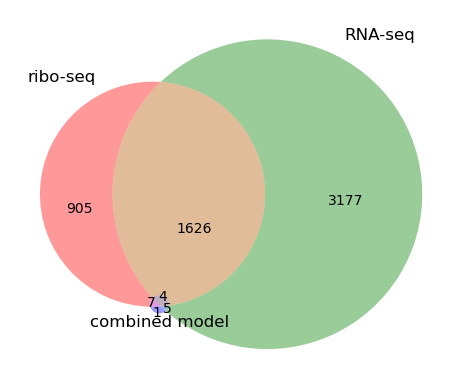

In [45]:
from matplotlib_venn import venn3
venn3((DE_ribo_set, DE_RNA_set, DE_model_set), set_labels = ('ribo-seq', 'RNA-seq', 'combined model'))

Interestingly, out of this 17 genes, there is only 1 gene which is neither in ribo DE-genes nor in RNA-seq DE_genes. Let's check which gene it is. 

In [46]:
DE_model_set - (DE_RNA_set | DE_ribo_set)

{'CDK5R1'}

The protein encoded by this gene (p35) is a neuron-specific activator of cyclin-dependent kinase 5 (CDK5); the activation of CDK5 is required for proper development of the central nervous system. The p35 form of this protein is proteolytically cleaved by calpain, generating a p25 form. The cleavage of p35 into p25 results in relocalization of the protein from the cell periphery to nuclear and perinuclear regions. P25 deregulates CDK5 activity by prolonging its activation and changing its cellular location. The p25 form accumulates in the brain neurons of patients with Alzheimer's disease. This accumulation correlates with an increase in CDK5 kinase activity, and may lead to aberrantly phosphorylated forms of the microtubule-associated protein tau, which contributes to Alzheimer's disease.

In [47]:
counts.head(2)

,LC001-normal-RPF,LC001-tumor-RPF,LC033-normal-RPF,LC033-tumor-RPF,LC034-normal-RPF,LC034-tumor-RPF,LC501-normal-RPF,LC501-tumor-RPF,LC502-normal-RPF,LC502-tumor-RPF,...,LC507-tumor-RNA,LC508-normal-RNA,LC508-tumor-RNA,LC509-normal-RNA,LC509-tumor-RNA,mods_corr,ribo_average,ribo_var,ribo_average_log,ribo_var_log
0,0,0,0,0,0,0,0,0,0,0,...,457,200,889,161,857.0,0.000000,0.0,0.0,-inf,-inf
1,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0.0,-0.139424,0.1,0.1,-2.302585,-2.302585


Now, a few examples of checking how DE genes are compared to other genes

In [48]:
counts.index = genes

In [49]:
counts['set'] = 'Not_DE_genes'
counts.loc[counts.index.isin(DE_ribo_set), 'set'] = 'DE_ribo'
counts.loc[counts.index.isin(DE_RNA_set), 'set'] = 'DE_RNA'
counts.loc[counts.index.isin(DE_ribo_RNA_set), 'set'] = 'DE_RNA_and_ribo'
counts.loc[counts.index.isin(DE_model_set), 'set'] = 'DE_model_set'

In [50]:
counts['ribo_avg'] = counts.iloc[:,0:20].mean(axis = 1)
counts['RNA_avg'] = counts.iloc[:,20:40].mean(axis = 1)
counts['ribo_norm_avg'] = counts.iloc[:,0:20:2].mean(axis = 1)
counts['ribo_cancer_avg'] = counts.iloc[:,1:20:2].mean(axis = 1)
counts['RNA_norm_avg'] = counts.iloc[:,20:40:2].mean(axis = 1)
counts['RNA_canc_avg'] = counts.iloc[:,21:40:2].mean(axis = 1)

<AxesSubplot:xlabel='ribo_avg', ylabel='RNA_avg'>

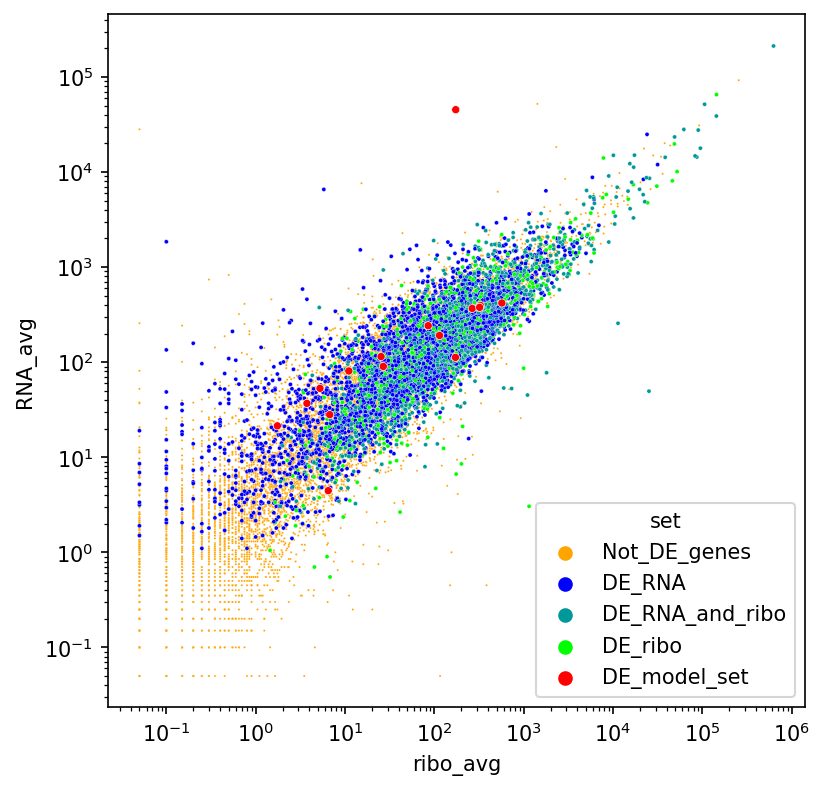

In [57]:
#it's actually impossible to see anything when everything is plotted
fig, ax = plt.subplots(figsize=(6, 6), dpi=150)
ax.set(xscale="log", yscale="log")
sns.scatterplot(data = counts[counts['set'].isin(['Not_DE_genes'])], x = 'ribo_avg', y = 'RNA_avg', hue = 'set', s = 1, ax = ax, 
               palette = {'Not_DE_genes':'#FFA500'})
sns.scatterplot(data = counts[~counts['set'].isin(['Not_DE_genes', 'DE_model_set'])], x = 'ribo_avg', y = 'RNA_avg', hue = 'set', s = 4, ax = ax,
               palette = {'DE_RNA_and_ribo':'#009999','DE_ribo':'#00FF00', 'DE_RNA':'#0000FF'})
sns.scatterplot(data = counts[counts['set'].isin(['DE_model_set'])], x = 'ribo_avg', y = 'RNA_avg', hue = 'set', s = 15, ax = ax,
               palette = {'DE_model_set':'#FF0000'})

<AxesSubplot:xlabel='ribo_norm_avg', ylabel='ribo_cancer_avg'>

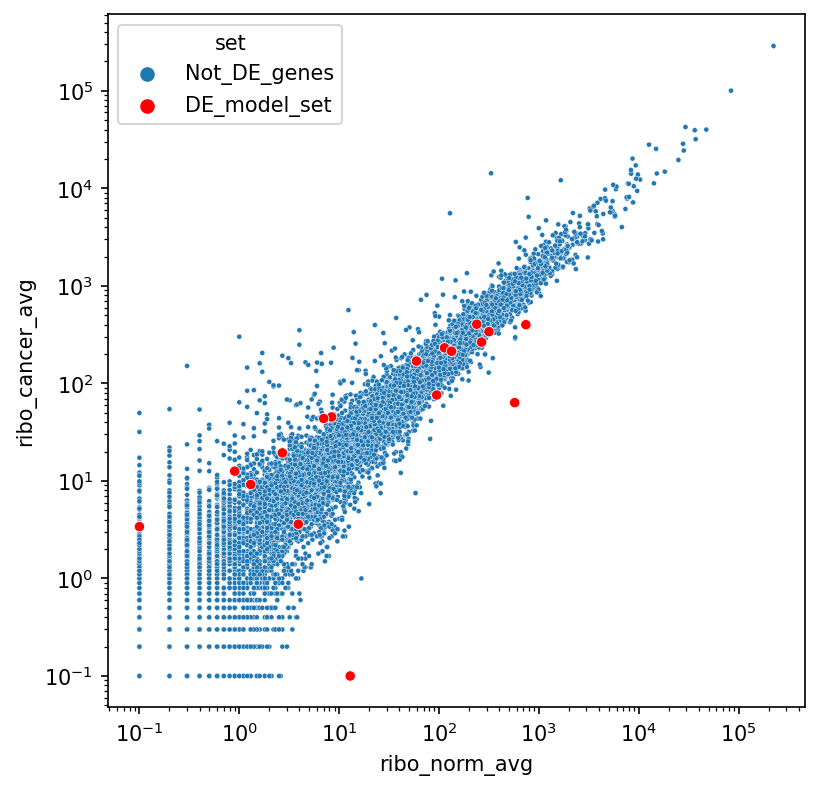

In [73]:
#plotting 17 genes from the last combined model on this graph doesn't yield anything interesting
fig, ax = plt.subplots(figsize=(6, 6), dpi=150)
ax.set(xscale="log", yscale="log")
sns.scatterplot(data = counts[counts['set'].isin(['Not_DE_genes'])], x = 'ribo_norm_avg', y = 'ribo_cancer_avg', hue = 'set', s = 6, ax = ax)
sns.scatterplot(data = counts[counts['set'].isin(['DE_model_set'])], x = 'ribo_norm_avg', y = 'ribo_cancer_avg', hue = 'set', s = 25, ax = ax,
               palette = {'DE_model_set': '#FF0000'})

In [63]:
counts.columns

Index(['LC001-normal-RPF', 'LC001-tumor-RPF', 'LC033-normal-RPF',
       'LC033-tumor-RPF', 'LC034-normal-RPF', 'LC034-tumor-RPF',
       'LC501-normal-RPF', 'LC501-tumor-RPF', 'LC502-normal-RPF',
       'LC502-tumor-RPF', 'LC505-normal-RPF', 'LC505-tumor-RPF',
       'LC506-normal-RPF', 'LC506-tumor-RPF', 'LC507-normal-RPF',
       'LC507-tumor-RPF', 'LC508-normal-RPF', 'LC508-tumor-RPF',
       'LC509-normal-RPF', 'LC509-tumor-RPF', 'LC001-normal-RNA',
       'LC001-tumor-RNA', 'LC033-normal-RNA', 'LC033-tumor-RNA',
       'LC034-normal-RNA', 'LC034-tumor-RNA', 'LC501-normal-RNA',
       'LC501-tumor-RNA', 'LC502-normal-RNA', 'LC502-tumor-RNA',
       'LC505-normal-RNA', 'LC505-tumor-RNA', 'LC506-normal-RNA',
       'LC506-tumor-RNA', 'LC507-normal-RNA', 'LC507-tumor-RNA',
       'LC508-normal-RNA', 'LC508-tumor-RNA', 'LC509-normal-RNA',
       'LC509-tumor-RNA', 'mods_corr', 'ribo_average', 'ribo_var',
       'ribo_average_log', 'ribo_var_log', 'set', 'ribo_avg', 'RNA_avg',
       '

<AxesSubplot:xlabel='mods_corr', ylabel='Count'>

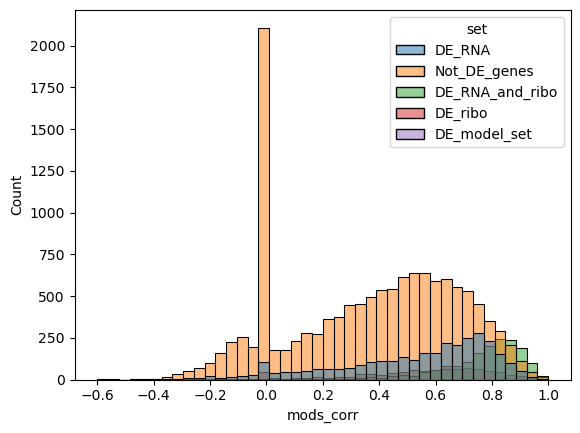

In [65]:
#let's look at how correlations between Ribo-seq and RNA-seq of different sets of genes compare to each other
sns.histplot(data = counts, x = 'mods_corr', hue = 'set' )

<AxesSubplot:xlabel='mods_corr', ylabel='set'>

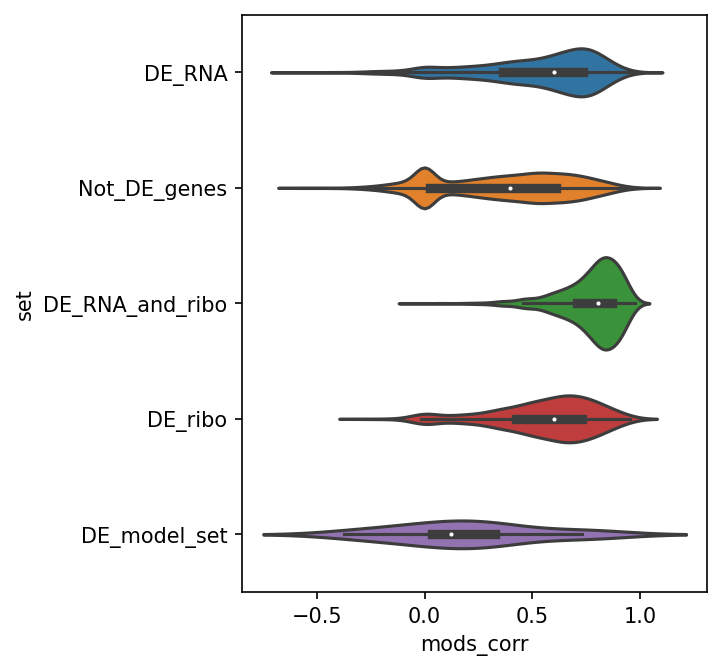

In [71]:
#let's check how correlation between Ribo-seq and RNA-seq is distributed for different differentially expressed sets
fig, ax = plt.subplots(figsize=(4, 5), dpi=150)
sns.violinplot(data = counts, x = 'mods_corr', y = 'set')

Nothing unexpected. As it can be seen, genes from the last model (~ condition + experiment + experiment:condition) are not genes which have strong correlation between Ribo-seq and RNA-seq. Which is only natural because of the model chosen. 

# 2. Wig analysis

In [29]:
import pandas as pd
import numpy as np

In [30]:
fribo = pd.read_csv('~/Uni/NGS/Ribo/HSE_RiboSeq_HT/02. RiboSeq_EColi_track_f.wig', skiprows = 1, 
                    header = None, index_col = None, sep = '\t')
rribo = pd.read_csv('~/Uni/NGS/Ribo/HSE_RiboSeq_HT/02. RiboSeq_EColi_track_r.wig', skiprows = 1, 
                    header = None, index_col = None, sep = '\t')

In [31]:
fribo.columns = ['nb', 'count']
rribo.columns = ['nb', 'count']
fribo.head(3)

,nb,count
0,40,1
1,77,2
2,85,1


In [32]:
#!pip install biopython

In [33]:
#parsing genbank file
#genbank file was acquired here https://www.ncbi.nlm.nih.gov/nuccore/545778205

import Bio
from Bio import SeqIO
with open('sequence.gb') as gb:
    gb = Bio.SeqIO.read(gb, 'gb')
gb

SeqRecord(seq=Seq(None, length=4641652), id='U00096.3', name='U00096', description='Escherichia coli str. K-12 substr. MG1655, complete genome', dbxrefs=['BioProject:PRJNA225', 'BioSample:SAMN02604091'])

In [34]:
#we are interested in CDSs
fts = []
for ft in gb.features:
    if ft.type == 'CDS':
        fts.append(ft)

In [35]:
#what a gbfile has
fts[0].__dict__

{'location': SimpleLocation(ExactPosition(189), ExactPosition(255), strand=1),
 'type': 'CDS',
 'id': '<unknown id>',
 'qualifiers': {'gene': ['thrL'],
  'locus_tag': ['b0001'],
  'gene_synonym': ['ECK0001'],
  'codon_start': ['1'],
  'transl_table': ['11'],
  'product': ['thr operon leader peptide'],
  'protein_id': ['AAC73112.1'],
  'db_xref': ['UniProtKB/Swiss-Prot:P0AD86',
   'ASAP:ABE-0000006',
   'ECOCYC:EG11277'],
  'translation': ['MKRISTTITTTITITTGNGAG']}}

In [36]:
# getting out the info we need
fts_table = []
for ft in fts:
    fts_table.append([ft.__dict__['location'].start,
                    ft.__dict__['location'].end,
                    ft.__dict__['location'].strand,
                    ft.qualifiers['gene'][0],
                     ])

In [37]:
fts_table = pd.DataFrame(fts_table, columns = ['start', 'end', 'strand', 'gene'])

In [38]:
fts_table.head(3)

,start,end,strand,gene
0,189,255,1,thrL
1,336,2799,1,thrA
2,2800,3733,1,thrB


255-189 = 66 = 22 aminoacids. Thus, we need to be aware that this is [0-base](http://17ihiw.org/wp-content/uploads/2016/10/20160925_SequenceCoordinates_ASHI2016.pdf)

In [39]:
#finding the 11 longest genes
tmp_df = fts_table['end'] - fts_table['start']
fts_table.iloc[tmp_df.sort_values(ascending = False).index[:11]]

,start,end,strand,gene
1389,1465391,1474013,1,ydbA
1964,2044937,2052014,1,yeeJ
2497,2647325,2652287,-1,yfhM
1645,1729086,1733703,1,lhr
2622,2778145,2782726,-1,ypjA
2924,3114549,3119112,-1,yghJ
899,976325,980786,1,mukB
3156,3354724,3359185,1,gltB
489,523260,527541,1,rhsD
3417,3619191,3623427,1,rhsB


# 2.1 Sequencing coverage

In [135]:
#I'll use 'rpoC' gene for the analysis
start = 4185349
end = 4189573

In [140]:
#since it's forward strand, using the data for forward wig
#no idea whether wig is 0-base or 1-base. It's probably 1-base https://www.biostars.org/p/384606/
#And if it's 1-base, I need to add 1 to the coordinates
fribo[fribo['nb'].between(start+1, end+1)]

,nb,count
554204,4185350,11
554205,4185351,145
554206,4185352,77
554207,4185353,23
554208,4185354,3
...,...,...
558150,4189569,568
558151,4189570,30
558152,4189571,5
558153,4189572,1


In [160]:
gene_cov = fribo[fribo['nb'].between(start+1, end+1)]
#some nb have 0 count. need to add them
all_nb = set(range(start+1, end+1))
non_zero_nb = set(gene_cov['nb'])
zero_nb = all_nb - non_zero_nb
gene_cov = gene_cov.set_index('nb')
for nb in list(zero_nb):
    gene_cov.loc[nb] = 0
gene_cov = gene_cov.sort_values(by = 'nb', ascending = True)
gene_cov[0:12]

,count
nb,
4185350,11
4185351,145
4185352,77
4185353,23
4185354,3
4185355,15
4185356,2
4185357,48
4185358,34


<AxesSubplot:xlabel='nb'>

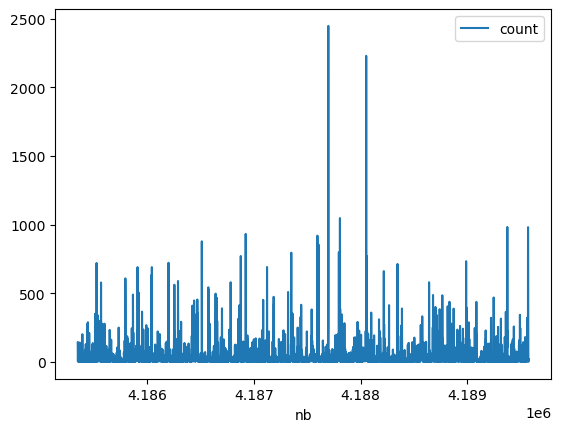

In [161]:
#plotting. But the picture needs some tinkering
sns.lineplot(gene_cov)

In [163]:
tmp = gene_cov.reset_index()
tmp['nb'] = tmp['nb'] - start
tmp = tmp.set_index('nb')

<AxesSubplot:xlabel='nb'>

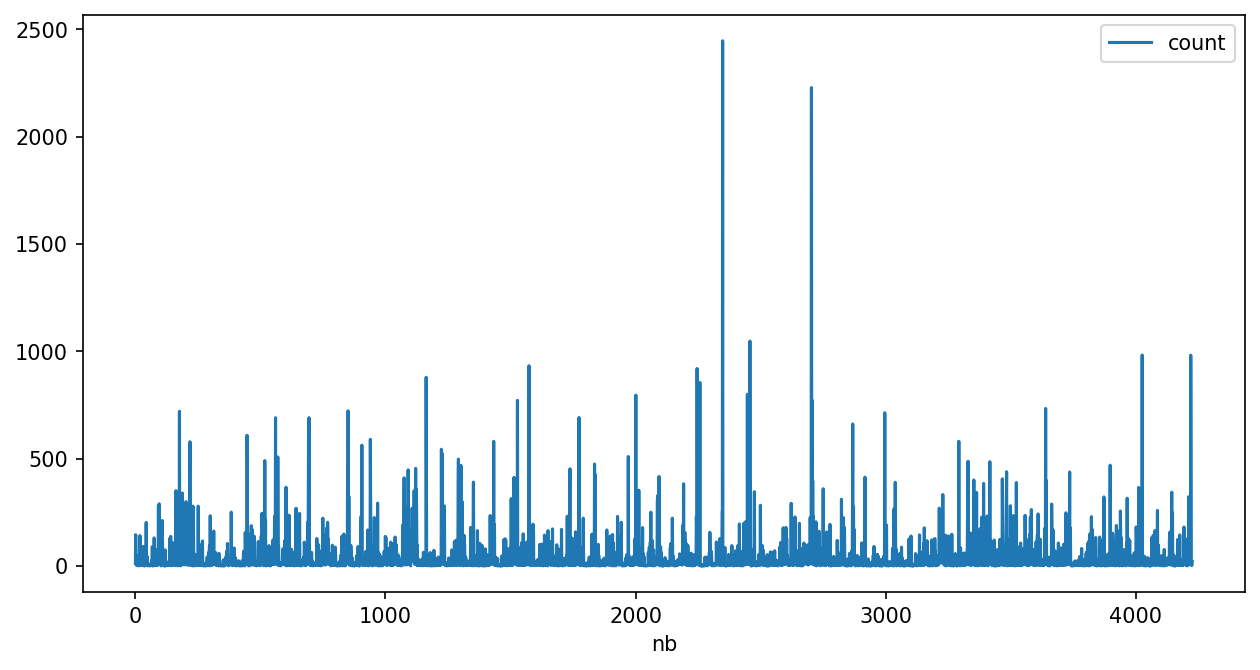

In [165]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=150)
sns.lineplot(tmp)

It can be seen that the coverage on microscale is very uneven. Many peaks of various magnitude neighbor less covered nucleotides. <br>
Let's zoom in.

<AxesSubplot:xlabel='nb'>

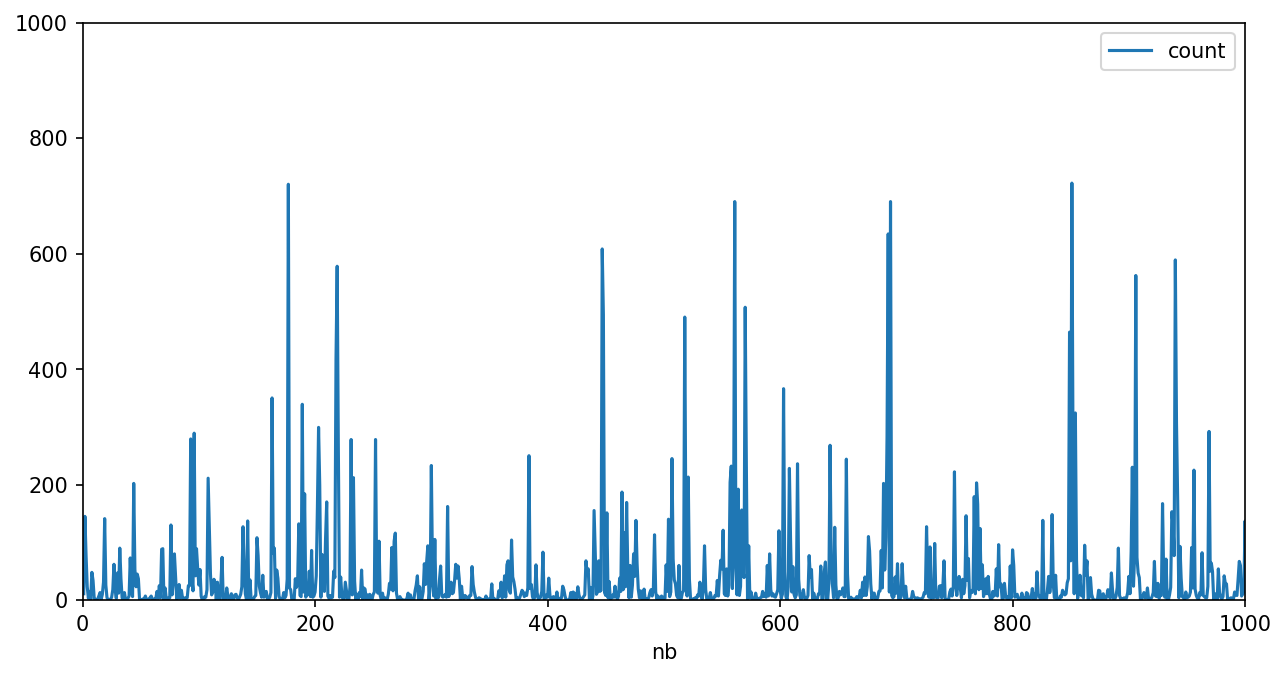

In [171]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=150)
ax.set_xlim(0, 1000)
ax.set_ylim(0, 1000)
sns.lineplot(tmp)

And zoom in still more to look if there are periods of length 3 in peaks

<AxesSubplot:xlabel='nb'>

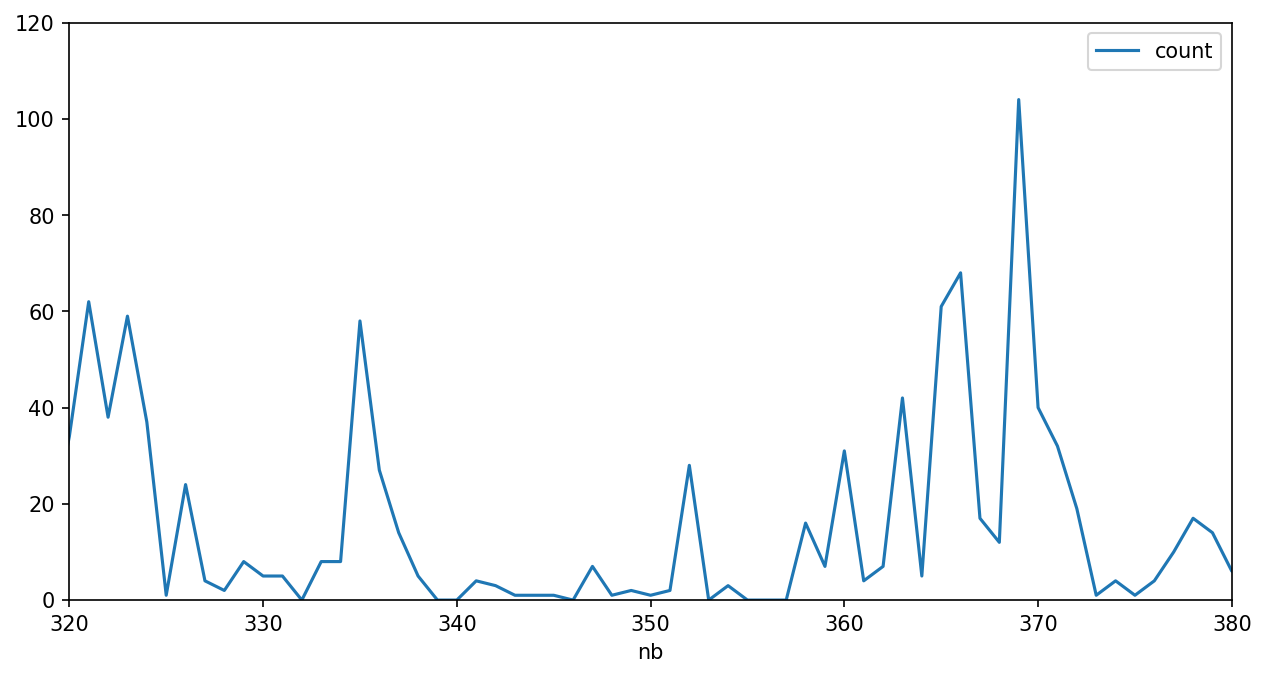

In [170]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=150)
ax.set_xlim(320,380)
ax.set_ylim(0,120)
sns.lineplot(tmp)

There is something remininding peaks with period of 3 between 360 and 370. But apart from that it's hard to see obvious connection. 
Let's sum up every first, second, third nucleotides and see if one of these 3 positions is more present than another

<AxesSubplot:>

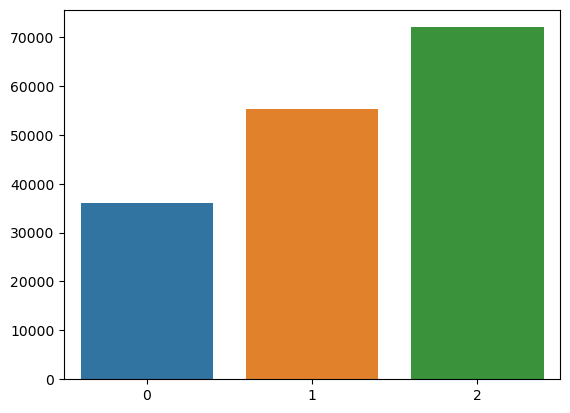

In [174]:
sns.barplot([tmp.iloc[::3].sum(), tmp.iloc[1::3].sum(), tmp.iloc[2::3].sum(),])

At least for this gene, nucleotides in codon are covered differently on average

Now taking average for all the genes. In order to do so I'm going to determine first how long the genes are.

<AxesSubplot:xlabel='length', ylabel='Count'>

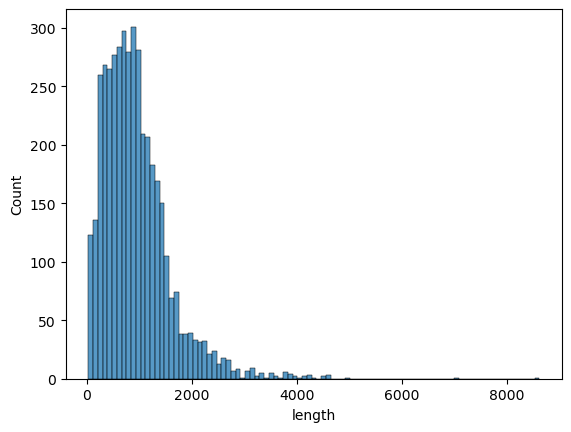

In [17]:
fts_table['length'] = fts_table['end'] - fts_table['start']
sns.histplot(fts_table['length'])

In [177]:
fts_table['length'].median()

825.0

Averaging over all the genes would take some time to compute.
Let's use genes with length 501..550 and look at 501 first nucleotdies to speed up the calculations

In [203]:
fts_table[fts_table['length'].between(501,550)] #143 such genes

,start,end,strand,gene,length
20,19810,20314,-1,insB1,504
45,47245,47776,1,kefF,531
97,107704,108217,1,secM,513
124,141430,141967,1,hpt,537
146,161500,162031,-1,thpR,531
...,...,...,...,...,...
4224,4543727,4544267,1,fimI,540
4227,4547741,4548272,1,fimF,531
4228,4548284,4548788,1,fimG,504
4273,4600977,4601517,-1,dnaT,540


In [205]:
genes500 = fts_table[fts_table['length'].between(501,550)]

In [212]:
#Turning the code above into a function
def cov_vector(ix):
    
    start = genes500.loc[ix, 'start']
    end = genes500.loc[ix, 'end']

    
    
    # need to account for different strands
    strand = genes500.loc[ix, 'strand']
    if strand == 1:
        
        gene_cov = fribo[fribo['nb'].between(start+1, end)]

        #some nb have 0 count. need to add them
        all_nb = set(range(start+1, end+1))
        non_zero_nb = set(gene_cov['nb'])
        zero_nb = all_nb - non_zero_nb
        gene_cov = gene_cov.set_index('nb')
        for nb in list(zero_nb):
            gene_cov.loc[nb] = 0
        gene_cov = gene_cov.sort_values(by = 'nb', ascending = True)
    
        vector500 =  gene_cov['count'][0:501:1]
    
    
    if strand == -1:
      
        gene_cov = rribo[rribo['nb'].between(start+1, end)]


        #some nb have 0 count. need to add them
        all_nb = set(range(start+1, end+1))
        non_zero_nb = set(gene_cov['nb'])
        zero_nb = all_nb - non_zero_nb
        gene_cov = gene_cov.set_index('nb')
        for nb in list(zero_nb):
            gene_cov.loc[nb] = 0
        gene_cov = gene_cov.sort_values(by = 'nb', ascending = True)
        
        #reverse strand starts transcription from the different side. 
        #need to reverse the order of counts
        vector500 = list(gene_cov['count'][-1:-502:-1])   
    
    return np.array(vector500)

In [213]:
#IT TAKES ABOUT A MINUTE FOR THE CELL BELOW TO RUN

In [ ]:
coverage_matrix = []
for ix in list(genes500.index):
    print(ix)
    coverage_matrix.append(cov_vector(ix)) #this function returns counts for first 500 nucleotides of a gene (beginning from start codone)

In [220]:
coverage_matrix = np.stack(coverage_matrix, axis=0) #making a 2d matrix
coverage_matrix.shape #143 genes, 501 count

(143, 501)

<AxesSubplot:>

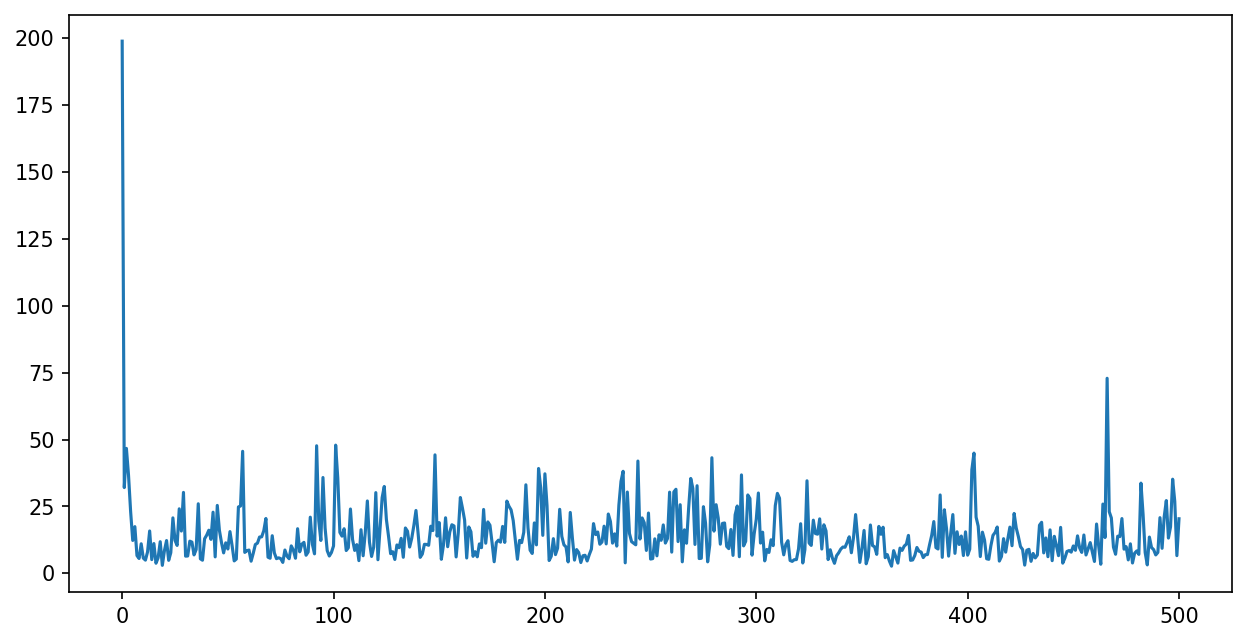

In [223]:
#drawing with averaging by genes
fig, ax = plt.subplots(figsize=(10, 5), dpi=150)
# ax.set_xlim(320,380)
# ax.set_ylim(0,120)
sns.lineplot(coverage_matrix.mean(axis=0))

We can see that zeroth nucleotide easily overshoots all the other positions. Zooming in for checking for 3-periodicity

<AxesSubplot:>

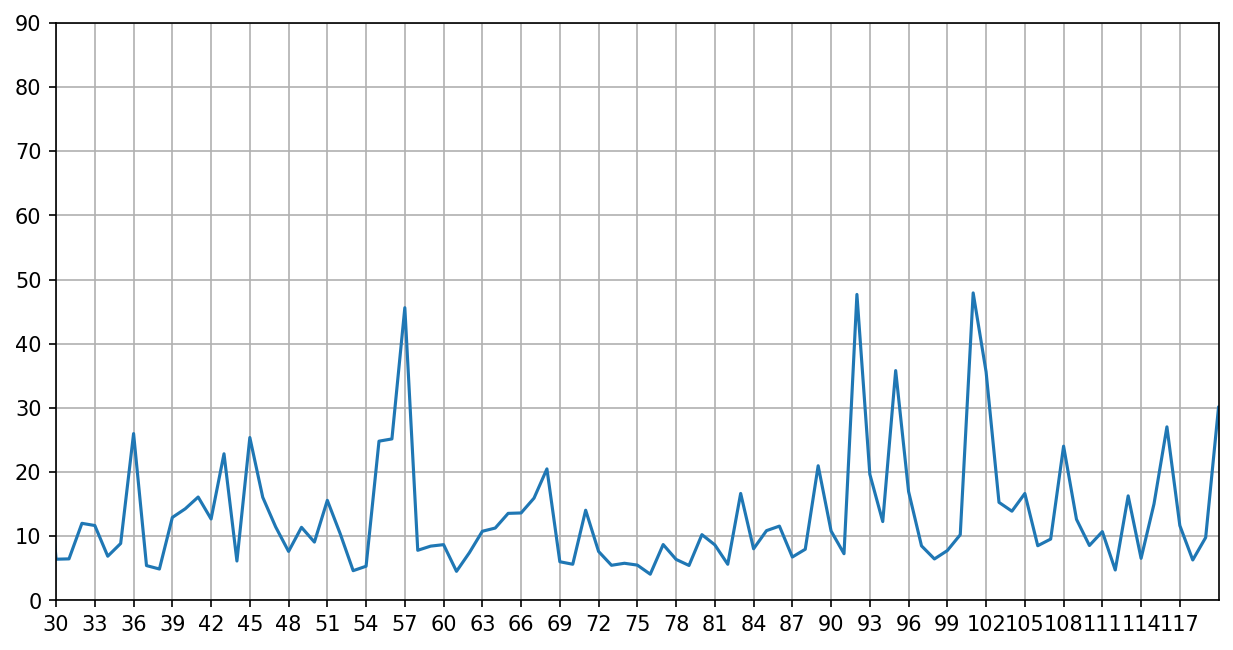

In [226]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=150)
ax.set_xlim(30,120)
ax.set_ylim(0,90)
ticks = range(30,120,3)
ax.set_xticks(ticks)
ax.grid()
sns.lineplot(coverage_matrix.mean(axis=0))

It looks like there is some periodicity in peaks between 66 and 96 (68,71,74,77 etc.) but the data still is very noisy

# 2.2 RPKM vs TPM

The difference between RPKM and TPM is in order of operations https://www.rna-seqblog.com/rpkm-fpkm-and-tpm-clearly-explained/ (also the original video)
TPM divides transcripts by the length of genes first and scales seconds. While RPKM scales first and then divides by the length. <br>
TPM always yields 1 million as its sum. Sum of RPKM varies every time.

In [40]:
#getting read counts per every gene

In [41]:
#there are duplicates in the table.
fts_table[fts_table['gene'] == 'mrcB']

,start,end,strand,gene
148,164729,167264,1,mrcB
149,164864,167264,1,mrcB


In [42]:
#dropping duplicates
fts_table_saved = fts_table.copy()
fts_table = fts_table.drop_duplicates('gene', keep = 'first')

In [43]:
fts_table['raw_count'] = 0
fts_table.head()

,start,end,strand,gene,raw_count
0,189,255,1,thrL,0
1,336,2799,1,thrA,0
2,2800,3733,1,thrB,0
3,3733,5020,1,thrC,0
4,5233,5530,1,yaaX,0


In [ ]:
gene_count = fts_table.set_index('gene')
for gene in list(gene_count.index):
    
    if gene_count.loc[gene,'strand'] == +1:
        start = gene_count.loc[gene, 'start']
        end = gene_count.loc[gene, 'end']
        gene_count.loc[gene,'raw_count'] = (fribo[fribo['nb'].between(start+1, end)]['count']).sum()       
           
    if gene_count.loc[gene,'strand'] == -1:
        start = gene_count.loc[gene, 'start']
        end = gene_count.loc[gene, 'end']
        gene_count.loc[gene,'raw_count'] = (rribo[rribo['nb'].between(start, end-1)]['count']).sum() 

In [45]:
gene_count

,start,end,strand,raw_count
gene,,,,
thrL,189,255,1,811
thrA,336,2799,1,34298
thrB,2800,3733,1,6705
thrC,3733,5020,1,19613
yaaX,5233,5530,1,121
...,...,...,...,...
creD,4638177,4639530,1,19
arcA,4639589,4640306,-1,11457
yjjY,4640401,4640542,1,0


Calculate TPM. Step 1: normalize for gene length

In [49]:
gene_count['length'] =  gene_count['end'] - gene_count['start']

In [50]:
gene_count['TPM'] = gene_count['raw_count']*1000/gene_count['length']

Calculate TPM. Step 2. Normalize per million

In [51]:
scale_factor = gene_count['TPM'].sum()/ 1e6
gene_count['TPM'] = gene_count['TPM']/scale_factor
gene_count['TPM']

gene
thrL    306.068267
thrA    346.853251
thrB    179.002264
thrC    379.583099
yaaX     10.147763
           ...    
creD      0.349782
arcA    398.009230
yjjY      0.000000
ytjE     42.897361
yjtD     20.086044
Name: TPM, Length: 4305, dtype: float64

In [52]:
gene_count['TPM'].sum() # "exactly" 1 million

1000000.0000000002

Calculate RPKM. Step 1. Normalize per million

In [53]:
scale_factor = gene_count['raw_count'].sum()/ 1e6
gene_count['RPKM'] = gene_count['raw_count']/scale_factor
gene_count['RPKM'].sum()

999999.9999999999

Calculate RPKM. Step 2. Divide per kilobase

In [54]:
gene_count['RPKM'] = gene_count['RPKM']*1000/gene_count['length']
gene_count['RPKM']

gene
thrL    507.586602
thrA    575.224819
thrB    296.859102
thrC    629.504317
yaaX     16.829149
           ...    
creD      0.580082
arcA    660.062392
yjjY      0.000000
ytjE     71.141402
yjtD     33.310892
Name: RPKM, Length: 4305, dtype: float64

In [55]:
gene_count['RPKM'].sum()

1658409.763310153

The difference between the two is just proportional, though. In this particular case counts for RPKM are ~ 1.65 greater than for TPM

# 2.3 ATP

In [59]:
#searching genes by ATP/atp
gene_count[gene_count.index.str.contains('atp')]

,start,end,strand,raw_count,length,TPM,RPKM
gene,,,,,,,
atpC,3915552,3915972,-1,11562,420,685.685650,1137.147776
atpD,3915992,3917375,-1,82586,1383,1487.392672,2466.706529
atpG,3917401,3918265,-1,12588,864,362.897835,601.833313
atpA,3918315,3919857,-1,73138,1542,1181.408503,1959.259395
atpH,3919869,3920403,-1,9528,534,444.428475,737.044523
atpF,3920417,3920888,-1,12480,471,659.986518,1094.528085
atpE,3920949,3921189,-1,70001,240,7264.979418,12048.312796
atpB,3921235,3922051,-1,22857,816,697.702783,1157.077107
atpI,3922059,3922440,-1,517,381,33.799241,56.052992


Judging by info from [https://academic.oup.com/nar/article/9/20/5287/1112588](this article) there are really 9 genes within the operon.
From the dataframe above it can be easily seen that the genes from the operon start at 3 922 439 and goes to 3 915 552 reverse-strand, 0-base. 
However, according to the aforementioned article, it also includes a promoter which promotes the translation of all the 9 genes. Let's check genebank if it has information on promoter

In [63]:
fts = []
for ft in gb.features:
    fts.append(ft)

In [66]:

fts_table = []
for ft in fts:
    fts_table.append([ft.__dict__['type'],
                      ft.__dict__['location'].start,
                    ft.__dict__['location'].end,
                    ft.__dict__['location'].strand,
                     ])

In [67]:
fts_table = pd.DataFrame(fts_table, columns = ['type','start', 'end', 'strand'])

In [73]:
fts_table[fts_table['start'].between(3913000,3924000)]

,type,start,end,strand
7857,gene,3913829,3915200,-1
7858,CDS,3913829,3915200,-1
7859,gene,3915552,3915972,-1
7860,CDS,3915552,3915972,-1
7861,gene,3915992,3917375,-1
7862,CDS,3915992,3917375,-1
7863,gene,3917401,3918265,-1
7864,CDS,3917401,3918265,-1
7865,gene,3918315,3919857,-1
7866,CDS,3918315,3919857,-1


Genebank says nothing about promoters, but it's know that promoters are two sequences 10, 35 bp upstream so coordinates would be something like 3 922 400 ... 3 915 552

In [74]:
gene_count[gene_count.index.str.contains('atp')]

,start,end,strand,raw_count,length,TPM,RPKM
gene,,,,,,,
atpC,3915552,3915972,-1,11562,420,685.685650,1137.147776
atpD,3915992,3917375,-1,82586,1383,1487.392672,2466.706529
atpG,3917401,3918265,-1,12588,864,362.897835,601.833313
atpA,3918315,3919857,-1,73138,1542,1181.408503,1959.259395
atpH,3919869,3920403,-1,9528,534,444.428475,737.044523
atpF,3920417,3920888,-1,12480,471,659.986518,1094.528085
atpE,3920949,3921189,-1,70001,240,7264.979418,12048.312796
atpB,3921235,3922051,-1,22857,816,697.702783,1157.077107
atpI,3922059,3922440,-1,517,381,33.799241,56.052992


As we can see on the table above, RPKM for genes from the same operon is vary by the orders of magnitude which shouldn't be the case for RNA-seq since the nature of the operon is that genes on the operon are transcribed jointly in succession one after another.

The difference comes from the fact that different transcripts are transcribed with different intensity because of factors which interfere with mRNA before it is able to reach the ribosome and when it's being translated. For example, translation can be modulated in such a way that the same transcript can be translated several times in a row. RNA-seq wouldn't able to capture that because these factors only come into play after the transcription is already in process. 